In [29]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk
from netket.operator.spin import sigmaz

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
L = 4
graph = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# Define the Hilbert space based on this graph
# h-J1 model is not spin conserved
hi = nk.hilbert.Spin(s=0.5, N=graph.n_nodes)

In [53]:
hfield = 0.6
J = 1
# calling the Heisenberg Hamiltonian
ha_heisenberg = J * nk.operator.Heisenberg(hilbert=hi, graph=graph)

# creating the B-field hamiltonian
ha_hfield = sum([hfield*sigmaz(hi,i) for i in range(hi.size)])
ha = ha_hfield + ha_heisenberg
#ha = ha_heisenberg

In [54]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals, evecs = nk.exact.lanczos_ed(ha, k = 1, compute_eigenvectors=True)
exact_gs_energy = evals[0]
gs = evecs[:,0]
print('The exact ground-state energy is E0=',exact_gs_energy)


The exact ground-state energy is E0= -44.91393283371547


In [55]:
Szs = sum([sigmaz(hi,i) for i in range(hi.size)])
Szcorr = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])

print("The exact value of <Sz> is ", gs @ (Szs @ gs))
print("The exact value of <SzSz> is ", gs @ (Szcorr @ gs))

The exact value of <Sz> is  -1.260314809934248e-27
The exact value of <SzSz> is  -14.971310944571822


## RBM

In [25]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

In [26]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=graph)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=3000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=3000 (3000 per device/MPI rank) does not divide n_chains=16, increased to 3008 (3008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 288 parameters
The RBM calculation took 60.56199407577515 seconds


In [28]:
energy_RBM

[-31.408422996315977,
 -31.9479309164328,
 -32.26809391343472,
 -34.74525458041183,
 -35.90383792404962,
 -36.42063645414703,
 -36.50718022727232,
 -37.05621476548514,
 -37.039197341596086,
 -37.12101790080971,
 -36.86942596114391,
 -36.97790733174909,
 -36.88888297720186,
 -37.11562872008118,
 -37.0106536948726,
 -37.18043996394192,
 -36.954920209138805,
 -36.92106102510052,
 -36.754659584025596,
 -36.82923929990551,
 -36.43978811026499,
 -36.63752566627932,
 -36.272538282418054,
 -36.368762270876786,
 -36.570252664517206,
 -36.304076579959904,
 -36.60765148141191,
 -36.49730524382717,
 -36.646704079675445,
 -36.54424926271692,
 -36.65484551154708,
 -36.55796970962685,
 -36.6143461737013,
 -36.642179694908315,
 -37.021703890344334,
 -36.72689115292649,
 -36.911353736032574,
 -37.105242581098175,
 -37.16424493098601,
 -37.20289651995802,
 -37.27457445212238,
 -37.28112577901517,
 -37.279793429178014,
 -37.37650725625017,
 -37.4017080312087,
 -37.4557685142095,
 -37.420136322247586,
 -3

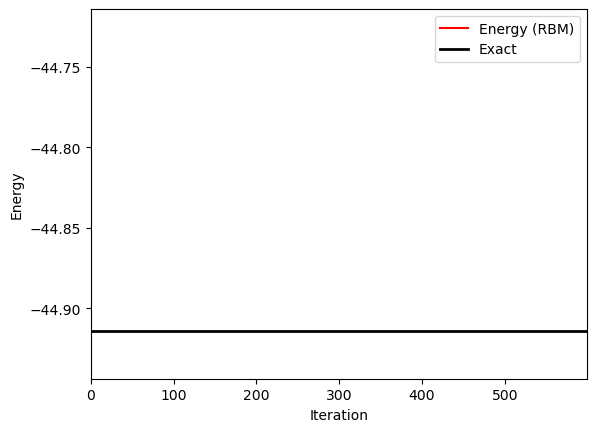

In [27]:
# import the data from log file
data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]
    
fig, ax1 = plt.subplots()
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()